<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Load pickled data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

#! cd /content/drive/MyDrive/stress-prediction/ # Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

import joblib
data = joblib.load(f"{PATH}/pickle/WESAD_data_model.pickle") # read pickle file
labels = joblib.load(f"{PATH}/pickle/WESAD_labels_model.pickle") # read pickle file

Mounted at /content/drive


In [5]:
# Subsample the data and features
Hz_chest = 700
Hz_EDA = 4
subsample_rate = int(Hz_chest / Hz_EDA)  # subsample rate, e.g. to reduce from 700Hz to 4Hz

subsampled_data = data[::subsample_rate]
subsampled_labels = labels[::subsample_rate]

print(len(data))  # 2742499
print(len(subsampled_data))  # 15672

2742499
15672


In [6]:
# Check for NaN values
subsampled_data.isnull().values.any()

False

In [7]:
# Try with a Datagenerator to reduce the RAM use
from keras.preprocessing.sequence import TimeseriesGenerator
random_state = 42
sampling_rate = 5 # keep one data point out of 5
duration = 1 # how many minutes in the future the target after the end of the sequence
sequence_length = Hz_EDA * 60 * duration # observations will go back duration minutues
delay = sampling_rate*(sequence_length + duration*60*Hz_EDA - 1) # the target for a
                                                             # sequence will be
                                                             # duration (min)
                                                             # after the end of
                                                             # the sequence
batch_size = 64
shuffle = True

# Train Test Split
from sklearn.model_selection import train_test_split

X_dat, X_val, y_dat, y_val = train_test_split(subsampled_data, subsampled_labels, 
                                                 test_size = 0.2,
                                                 random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X_dat, y_dat,
                                                    test_size = 0.2,
                                                    random_state = random_state)


# Normalize the data
from sklearn.preprocessing import StandardScaler
# create the StandardScaler object
scaler = StandardScaler()
# fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1,1))
# transform the validation data
X_val_scaled = scaler.transform(X_val.values.reshape(-1,1))
# transform the test data
X_test_scaled = scaler.transform(X_test.values.reshape(-1,1))

# Data Generator
train_data_gen = TimeseriesGenerator(X_train_scaled, y_train, length=sequence_length, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val_scaled, y_val, length=sequence_length, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test_scaled, y_test, length=sequence_length, batch_size=batch_size)

In [20]:
print(train_data_gen[0][0].shape) # prints the batch size of the first entry
'''
A tensor of shape (32, 1200, 1) means that it is a 3-dimensional tensor with 32 
rows, 240 columns and 1 channel. In this specific case, it could represent a 
batch of 32 time series samples, each with 1200 time steps and 1 feature/channel.

The first dimension (32) represents the batch size, which is the number of 
samples that are processed at once during training. The second dimension (1200) 
represents the time steps or the sequence length of each sample, and the third 
dimension (1) represents the number of features or channels in each sample.
'''

1


'\nA tensor of shape (32, 1200, 1) means that it is a 3-dimensional tensor with 32 \nrows, 240 columns and 1 channel. In this specific case, it could represent a \nbatch of 32 time series samples, each with 1200 time steps and 1 feature/channel.\n\nThe first dimension (32) represents the batch size, which is the number of \nsamples that are processed at once during training. The second dimension (1200) \nrepresents the time steps or the sequence length of each sample, and the third \ndimension (1) represents the number of features or channels in each sample.\n'

In [9]:
train_iterator = iter(train_data_gen)
x_batch, y_batch = next(train_iterator)
print(x_batch.shape)
print(y_batch.shape)

# Validation Data
val_iterator = iter(val_data_gen)
x_batch, y_batch = next(val_iterator)
print(x_batch.shape)
print(y_batch.shape)

(64, 240, 1)
(64,)
(64, 240, 1)
(64,)


In [32]:
# Naive Model
def evaluate_naive_method(dataset):
  '''
  This method uses a common-sense approach to predict that the subject will be
  in the same state 5 minutes from now as they are in now.
  '''
  

In [28]:
type(train_data_gen[0][0].shape[2])
print(sequence_length)

240


In [68]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.layers import LSTM, Dense

# Callbacks Function
def callbacks(checkpoint_file, early_stopping=True):
  from keras.callbacks import EarlyStopping, ModelCheckpoint
  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', verbose=1, patience=3,
                             restore_best_weights=True,
                             mode='min'),
              ModelCheckpoint(checkpoint_file,
               save_best_only=True)
  ]
  return callbacks

inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_0 = keras.Model(inputs, outputs)

model_0.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.001), 
              metrics=['binary_accuracy'])

epochs = 50
history_0 = model_0.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks('models/model_dense.keras'))

model_0_eval_val = model_0.evaluate(val_data_gen)
print(f'Val Binary Accuracy is: {model_0_eval_val[1]:.2f}[')
model_0_eval_test = model_0.evaluate(test_data_gen)
print(f'Val Binary Accuracy is: {model_0_eval_test[1]:.2f}[')

Epoch 1/50
153/153 [==============================] - 2s 7ms/step - loss: 4.6248 - binary_accuracy: 0.5852 - val_loss: 3.7519 - val_binary_accuracy: 0.6535
Epoch 2/50
153/153 [==============================] - 1s 3ms/step - loss: 3.4421 - binary_accuracy: 0.6921 - val_loss: 2.9720 - val_binary_accuracy: 0.7371
Epoch 3/50
153/153 [==============================] - 1s 3ms/step - loss: 2.9121 - binary_accuracy: 0.7522 - val_loss: 2.8517 - val_binary_accuracy: 0.7737
Epoch 4/50
153/153 [==============================] - 1s 4ms/step - loss: 2.7108 - binary_accuracy: 0.7835 - val_loss: 2.7995 - val_binary_accuracy: 0.7827
Epoch 5/50
153/153 [==============================] - 1s 3ms/step - loss: 2.6027 - binary_accuracy: 0.8020 - val_loss: 2.7989 - val_binary_accuracy: 0.7900
Epoch 6/50
153/153 [==============================] - 1s 3ms/step - loss: 2.5326 - binary_accuracy: 0.8149 - val_loss: 2.7946 - val_binary_accuracy: 0.7938
Epoch 7/50
153/153 [==============================] - 1s 3ms/ste

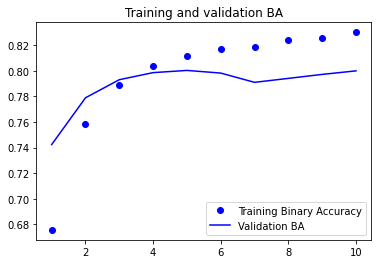

In [36]:
import matplotlib.pyplot as plt
loss = history_0.history["binary_accuracy"]
val_loss = history_0.history["val_binary_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training Binary Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation BA")
plt.title("Training and validation BA")
plt.legend()
plt.show()

In [53]:
def plot_evaluation(model, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'{file_name}')
    plt.show()

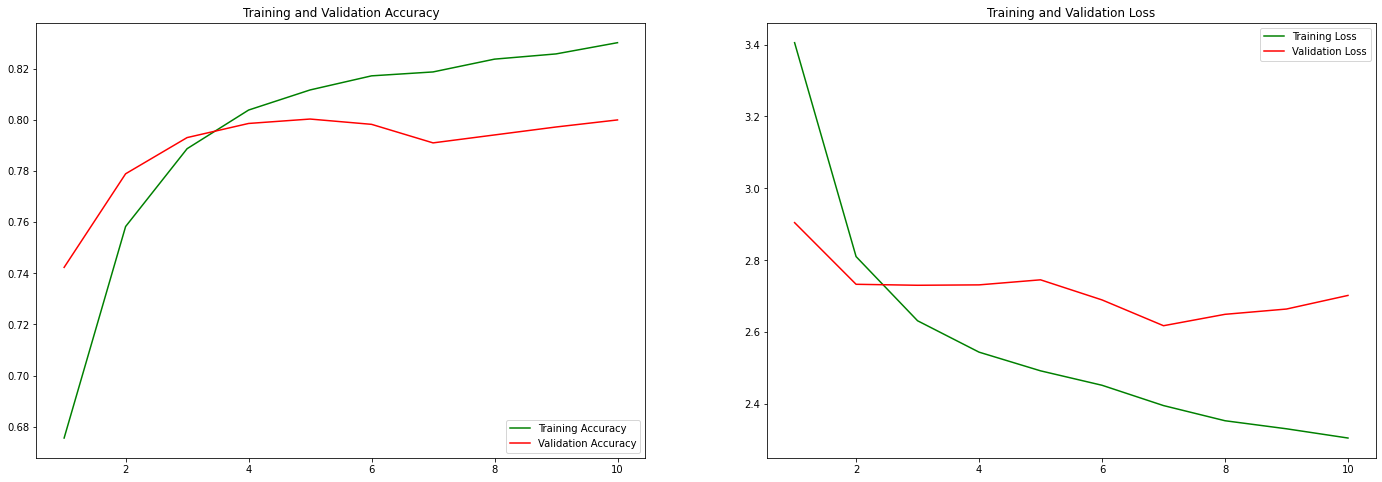

In [54]:
os.chdir('/content/drive/MyDrive/stress-prediction')
plot_evaluation(history_0, 'models/evaluate/model_0_evaluation.pdf')

In [69]:
'''
Model_1: Simple LSTM Model
Timeseries data is a sequence, where causality and sequence matter.
'''
from keras.callbacks import EarlyStopping, ModelCheckpoint

inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
x = LSTM(batch_size, activation='relu', input_shape=(sequence_length, 1))(inputs)
outputs = layers.Dense(1, activation='sigmoid')(x)          
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['binary_accuracy'])

# Train the model using the TimeSeriesGenerator
epochs = 10
history_1 = model_1.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks('models/model_lstm_1.keras'))

Epoch 1/10
153/153 [==============================] - 49s 309ms/step - loss: 0.6386 - binary_accuracy: 0.8131 - val_loss: 0.5968 - val_binary_accuracy: 0.8138
Epoch 2/10
153/153 [==============================] - 48s 314ms/step - loss: 0.5199 - binary_accuracy: 0.8142 - val_loss: 0.4805 - val_binary_accuracy: 0.8138
Epoch 3/10
153/153 [==============================] - 47s 305ms/step - loss: 0.4828 - binary_accuracy: 0.8142 - val_loss: 0.4803 - val_binary_accuracy: 0.8138
Epoch 4/10
153/153 [==============================] - 47s 304ms/step - loss: 27334222.0000 - binary_accuracy: 0.8142 - val_loss: 43.5362 - val_binary_accuracy: 0.8138
Epoch 5/10
153/153 [==============================] - 46s 304ms/step - loss: 17203.8926 - binary_accuracy: 0.8142 - val_loss: 0.4810 - val_binary_accuracy: 0.8138
Epoch 6/10
153/153 [==============================] - 46s 302ms/step - loss: 0.4839 - binary_accuracy: 0.8142 - val_loss: 0.4809 - val_binary_accuracy: 0.8138
Epoch 6: early stopping


Binary_accuracy and validation loss is stalling out around epoch 6-8. 

In [70]:
# Evaluate the model
model_1_eval_val = model_1.evaluate(val_data_gen)
print(f'Val Binary Accuracy is: {model_1_eval_val[1]:.2f}')
model_1_eval_test = model_0.evaluate(test_data_gen)
print(f'Val Binary Accuracy is: {model_1_eval_test[1]:.2f}')

46/46 [==============================] - 2s 33ms/step - loss: 0.4803 - binary_accuracy: 0.8138
Val Binary Accuracy is: 0.81
36/36 [==============================] - 0s 2ms/step - loss: 2.8069 - binary_accuracy: 0.7928
Val Binary Accuracy is: 0.79


In [79]:
'''
Model 2: Complex LSTM with Dropout
'''
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the LSTM model
inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
# Next model add a Dense layer here
x = LSTM(batch_size, 
         activation='relu', 
         input_shape=(sequence_length, 1),
         unroll=True,
         recurrent_dropout=0.5)(inputs)
#x = Dropout(0.5) # Dropout
x = Dense(units=batch_size//2, activation='relu')(x)
x = LSTM(batch_size//2, 
         activation='relu', 
         input_shape=(sequence_length, 1),
         unroll=True,
         recurrent_dropout=0.5)(inputs)
#x = Dropout(0.5) # Dropout
x = Dense(units=batch_size//2//2, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_2 = keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['binary_accuracy'])

# Train the model using the TimeSeriesGenerator
epochs = 50
history_2 = model_2.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks('models/model_lstm_2.keras'))


Epoch 1/50
153/153 [==============================] - 144s 284ms/step - loss: 0.6520 - binary_accuracy: 0.7738 - val_loss: 0.6108 - val_binary_accuracy: 0.8138
Epoch 2/50
153/153 [==============================] - 30s 193ms/step - loss: 347945729310041269338112.0000 - binary_accuracy: 0.8142 - val_loss: 0.5746 - val_binary_accuracy: 0.8138
Epoch 3/50
153/153 [==============================] - 29s 192ms/step - loss: 3984285717042823168.0000 - binary_accuracy: 0.8142 - val_loss: 0.5569 - val_binary_accuracy: 0.8138
Epoch 4/50
153/153 [==============================] - 29s 193ms/step - loss: 331052114336750239744.0000 - binary_accuracy: 0.8142 - val_loss: 0.5412 - val_binary_accuracy: 0.8138
Epoch 5/50
153/153 [==============================] - 29s 192ms/step - loss: 371280303328591872.0000 - binary_accuracy: 0.8142 - val_loss: 0.5286 - val_binary_accuracy: 0.8138
Epoch 6/50
153/153 [==============================] - 30s 194ms/step - loss: 14330651213824.0000 - binary_accuracy: 0.8142 - v

KeyboardInterrupt: ignored

In [88]:
''''
Model 3: Bidirectional LSTM
'''

# Define the LSTM model
inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
# Next model add a Dense layer here
x = Dense(units=batch_size, activation='relu')(inputs)
x = layers.Bidirectional(LSTM(batch_size, 
                          activation='relu', 
                          input_shape=(sequence_length, 1),
                          unroll=True,
                          recurrent_dropout=0.5))(x)
x = Dense(units=batch_size//2, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_3 = keras.Model(inputs, outputs)

# Compile
model_3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.00001), 
              metrics=['binary_accuracy'])

In [89]:
# Train the model using the TimeSeriesGenerator
epochs = 50
history_3 = model_3.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks('models/model_lstm_3.keras'))

Epoch 1/50
153/153 [==============================] - 351s 607ms/step - loss: 0.6978 - binary_accuracy: 0.4295 - val_loss: 0.6780 - val_binary_accuracy: 0.8066
Epoch 2/50
153/153 [==============================] - 63s 411ms/step - loss: 0.6562 - binary_accuracy: 0.8123 - val_loss: 0.6374 - val_binary_accuracy: 0.8138
Epoch 3/50
153/153 [==============================] - 63s 412ms/step - loss: 0.7278 - binary_accuracy: 0.8142 - val_loss: 0.5990 - val_binary_accuracy: 0.8138
Epoch 4/50
153/153 [==============================] - 63s 413ms/step - loss: 590928.1250 - binary_accuracy: 0.8142 - val_loss: 0.5789 - val_binary_accuracy: 0.8138
Epoch 5/50
153/153 [==============================] - 63s 413ms/step - loss: 114.6105 - binary_accuracy: 0.8140 - val_loss: 0.5736 - val_binary_accuracy: 0.8138
Epoch 6/50
153/153 [==============================] - 63s 412ms/step - loss: 429775872.0000 - binary_accuracy: 0.8142 - val_loss: 0.5698 - val_binary_accuracy: 0.8138
Epoch 7/50
153/153 [==========

In [90]:
# Evaluate the model
model_3_eval_val = model_1.evaluate(val_data_gen)
print(f'Val Binary Accuracy is: {model_3_eval_val[1]:.2f}')
model_3_eval_test = model_0.evaluate(test_data_gen)
print(f'Val Binary Accuracy is: {model_3_eval_test[1]:.2f}')

46/46 [==============================] - 2s 33ms/step - loss: 0.4802 - binary_accuracy: 0.8138
Val Binary Accuracy is: 0.81
36/36 [==============================] - 0s 2ms/step - loss: 2.8069 - binary_accuracy: 0.7928
Val Binary Accuracy is: 0.79
